In [1]:
import graphviz
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_cus = pd.read_csv("./Practice data/통신고객이탈.CSV",engine="python")

In [2]:
ds_cus.isnull().sum()

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [3]:
ds_cus["CHURN"].replace(to_replace = "Active", value = 0, inplace =True)
ds_cus["CHURN"].replace(to_replace = "Churned", value = 1, inplace =True)

In [4]:
np.random.seed(seed = 1234)
# 0.7 보다 작으면 True : train 데이터, 아니면 False: test 데이터
msk = np.random.rand(ds_cus.shape[0],)<0.7
ds_cus_train = ds_cus[msk]
ds_cus_test = ds_cus[~msk]
# train data 와 test data의 크기
print("train data size : {}".format(ds_cus_train.shape))
print("test data size : {}".format(ds_cus_test.shape))
ds_cus.head(1)

train data size : (635, 15)
test data size : (295, 15)


,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,0,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4


In [5]:
log_model = sm.Logit.from_formula("""CHURN~ C(GENDER)+AGE+C(CHARGE_TYPE)+C(HANDSET)+C(USAGE_BAND)+SERVICE_DURATION+ DROPPED_CALLS +PEAK_CALLS_NO+PEAK_CALLS_TIME+ WEEKEND_CALLS_NO+WEEKEND_CALLS_TIME+TOTAL_CALLS_NO+TOTAL_CALLS_TIME""",ds_cus_train)
#log_result = log_model.fit()
log_result=log_model.fit(method='bfgs')
print(log_result.summary())
# 나이는별로 영향을 안주는것 같다.
# CHARGE_TYPE도 어느 정도 영향
# HANDSET도 큰 영향을 주는 것 같다.

         Current function value: 0.261293
         Iterations: 35
         Function evaluations: 49
         Gradient evaluations: 42
                           Logit Regression Results                           
Dep. Variable:                  CHURN   No. Observations:                  635
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                           29
Date:                Fri, 01 Feb 2019   Pseudo R-squ.:                  0.4660
Time:                        15:04:56   Log-Likelihood:                -165.92
converged:                      False   LL-Null:                       -310.70
                                        LLR p-value:                 9.369e-45
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1342      2

C:\Users\admin1\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\admin1\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\admin1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [6]:
# 로지스틱 모델로 test 데이터 예측
y_pred = log_result.predict(ds_cus_test)
# 0과 의 값을 가진 class로 변환
y_pred_class = (y_pred > 0.5).astype(int)
# 상위 5건 출력
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int32

In [7]:
print("Accuracy:{0:.3f}".format(metrics.accuracy_score(ds_cus_test["CHURN"],y_pred_class)))

Accuracy:0.898


# Decision Tree

In [8]:
import graphviz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [9]:
plt.rc('font', family = 'NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [10]:
ds_hgme = pd.read_csv("./Practice data/HMEQ.csv", engine = "python")
ds_hgme.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [11]:
ds_hgme.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [12]:
ds_hgme["JOB"].fillna("Other", inplace = True)
ds_hgme.fillna(ds_hgme.mean(),inplace=True)

In [13]:
ds_hgme_dummy = pd.get_dummies(ds_hgme)
ds_hgme_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [14]:
np.random.seed(seed=1234)

msk = np.random.rand(ds_hgme_dummy.shape[0])<0.7
ds_hgme_train = ds_hgme_dummy[msk]
ds_hgme_test = ds_hgme_dummy[~msk]

ds_hgme_train_y = ds_hgme_train["BAD"]
ds_hgme_train_x = ds_hgme_train.drop("BAD",axis=1,inplace=False)
ds_hgme_test_y = ds_hgme_test["BAD"]
ds_hgme_test_x = ds_hgme_test.drop("BAD",axis=1,inplace=False)

print("train data X size : {}".format(ds_hgme_train_x.shape))
print("train data Y size : {}".format(ds_hgme_train_y.shape))
print("test data X size : {}".format(ds_hgme_test_x.shape))
print("test data Y size : {}".format(ds_hgme_test_y.shape))

train data X size : (2604, 18)
train data Y size : (2604,)
test data X size : (1144, 18)
test data Y size : (1144,)


In [15]:
from sklearn.model_selection import train_test_split

ds_hgme_y = ds_hgme_dummy["BAD"]
ds_hgme_x = ds_hgme_dummy.drop("BAD",axis=1,inplace = False)

ds_hgme_train_x2,ds_hgme_test_x2,ds_hgme_train_y2,ds_hgme_test_y2 = train_test_split(ds_hgme_x,ds_hgme_y,test_size = 0.30,random_state = 1234)

print("train data X size : {}".format(ds_hgme_train_x2.shape))
print("train data Y size : {}".format(ds_hgme_train_y2.shape))
print("test data X size : {}".format(ds_hgme_test_x2.shape))
print("test data Y size : {}".format(ds_hgme_test_y2.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [16]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(ds_hgme_train_x, ds_hgme_train_y)

print("Accurac on training set : {:.3f}".format(tree_uncustomized.score(ds_hgme_train_x,ds_hgme_train_y)))
print("Accurac on test set : {:.3f}".format(tree_uncustomized.score(ds_hgme_test_x,ds_hgme_test_y)))

Accurac on training set : 1.000
Accurac on test set : 0.927


In [17]:
tree_uncustomized.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')>

In [18]:
train_accuracy=[]
test_accuracy=[]

para_criterion = ["gini","entropy"]

for criterion in para_criterion:
    tree1 = DecisionTreeClassifier(criterion = criterion, random_state = 1234)
    tree1.fit(ds_hgme_train_x,ds_hgme_train_y)
    train_accuracy.append(tree1.score(ds_hgme_train_x,ds_hgme_train_y))
    test_accuracy.append(tree1.score(ds_hgme_test_x,ds_hgme_test_y))
    
ds_accuracy1 = pd.DataFrame()
ds_accuracy1["Criterion"] = para_criterion
ds_accuracy1["TrainAccuracy"] = train_accuracy
ds_accuracy1["TestAccuracy"] = test_accuracy
ds_accuracy1.round(3)



,Criterion,TrainAccuracy,TestAccuracy
0,gini,1.0,0.927
1,entropy,1.0,0.921


In [19]:
train_accuracy = [];test_accuracy = []
para_criterion = [];para_max_depth = []
n_iter_depth = 10
list_criterion = ["gini","entropy"]
for criterion in list_criterion:
    for depth in range(1,n_iter_depth+1):
        tree2 = DecisionTreeClassifier(criterion=criterion,max_depth = depth, random_state=1234)
        tree2.fit(ds_hgme_train_x,ds_hgme_train_y)
        
        train_accuracy.append(tree2.score(ds_hgme_train_x,ds_hgme_train_y))
        test_accuracy.append(tree2.score(ds_hgme_test_x,ds_hgme_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)

In [20]:
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["Depth"] = para_max_depth
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.924,0.927
1,gini,2,0.930,0.932
2,gini,3,0.931,0.932
3,gini,4,0.934,0.934
4,gini,5,0.937,0.934
5,gini,6,0.938,0.937
6,gini,7,0.944,0.934
7,gini,8,0.952,0.935
8,gini,9,0.959,0.936
9,gini,10,0.965,0.943


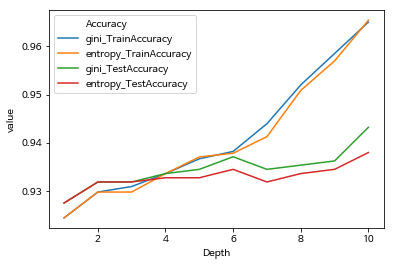

In [21]:
ds_accuracy2_melt = pd.melt(ds_accuracy2, id_vars = ["Criterion", "Depth"])
ds_accuracy2_melt["Accuracy"] = ds_accuracy2_melt["Criterion"] + "_" + ds_accuracy2_melt["variable"]
sns.lineplot(x="Depth", y="value", hue = "Accuracy", data = ds_accuracy2_melt)

In [22]:
train_accuracy = [];test_accuracy = []

para_criterion = []; para_max_depth = []; para_min_leaf_size = []

max_depth = 10

list_min_leaf_size = [i*10 for i in range(1,6)]

for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree3 = DecisionTreeClassifier(criterion=criterion,max_depth = max_depth, min_samples_leaf = leafsize, random_state=1234)
        tree3.fit(ds_hgme_train_x,ds_hgme_train_y)
        
        train_accuracy.append(tree3.score(ds_hgme_train_x,ds_hgme_train_y))
        test_accuracy.append(tree3.score(ds_hgme_test_x,ds_hgme_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)    

In [23]:
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["MinLeafSize"] = para_min_leaf_size
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3.round(3)

,Criterion,Depth,MinLeafSize,TrainAccuracy,TestAccuracy
0,gini,10,10,0.945,0.935
1,gini,10,20,0.931,0.924
2,gini,10,30,0.929,0.929
3,gini,10,40,0.926,0.924
4,gini,10,50,0.924,0.930
5,entropy,10,10,0.944,0.930
6,entropy,10,20,0.930,0.925
7,entropy,10,30,0.927,0.933
8,entropy,10,40,0.924,0.927
9,entropy,10,50,0.924,0.930


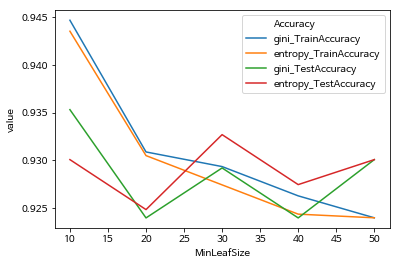

In [24]:
ds_accuracy3_melt = pd.melt(ds_accuracy3, id_vars = ["Criterion", "Depth","MinLeafSize"])
ds_accuracy3_melt["Accuracy"] = ds_accuracy3_melt["Criterion"] + "_" + ds_accuracy3_melt["variable"]
sns.lineplot(x="MinLeafSize", y="value", hue = "Accuracy", data = ds_accuracy3_melt)

In [26]:
tree = DecisionTreeClassifier(criterion="gini",max_depth=4,random_state=1234,max_depth=4)

tree.fit(ds_hgme_train_x,ds_hgme_train_y)

export_graphviz(tree,out_file="tree.dot",class_names=["0","1"],feature_names=ds_hgme_train_x.columns, impurity=False,filled=True)

os.environ["PATH"] += os.pathsep + ""

with open("tree.dot")as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

SyntaxError: keyword argument repeated (<ipython-input-26-b81fc3f064b4>, line 1)